This notebook pulls in the JSON from the getData.activities app file. I've saved the data locally for ease of use but you can either call the class into this notebook or incorporate some cells from this notebook into the main app as an additional class.
The rest of the notebook cleans and organizes the activities data and then trials some visualisations and applications

In [12]:
# Import packages
import pandas as pd
import json
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
import sklearn
import xgboost

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings("ignore")

In [42]:
# Select fields of interest for the dataframe and format datetime
data = open("data.json","r")
activities = json.loads(data.read())
df= pd.DataFrame(activities)
df= df[["athlete","name","distance","moving_time","elapsed_time","total_elevation_gain","type","average_temp","start_date_local","location_city","average_speed","average_heartrate","pr_count"]]
df=df.loc[df["distance"] != 0]

#Handle datetime vars
df['start_date_local']=pd.to_datetime(df['start_date_local'])
df['start_time']=df['start_date_local'].dt.time
df['start_date']=df['start_date_local'].dt.date
df['start_date']=pd.to_datetime(df['start_date'])
df['start_time']= pd.to_datetime(df['start_time'], format='%H:%M:%S')
df["elevationPerKM"]= df["total_elevation_gain"]/df["distance"]
#Drop swims
df=df.loc[df['type']!= "Swim"]
df.reset_index(drop=True,inplace=True)

#Separate the acitivities into types
#Runs
runs= df.loc[df["type"]=="Run"]
short_runs= runs.loc[df["distance"] <= 10000]
runs.reset_index(drop=True,inplace=True)
#Bike Rides
rides=df.loc[df["type"]=="Ride"]
rides.reset_index(drop=True,inplace=True)

With the data and fields of interest loaded, we can do some simple checks on the data.

Elevation/distance
- Am I slower when I go further or climb more?
- Does elevation affect my run or bike more?
- Is there a threshold level of elevation where performance drops a lot?

Length of time
- How much affect do longer workouts have on my pace?
- If I take a period of rest, how much condition do I lose?


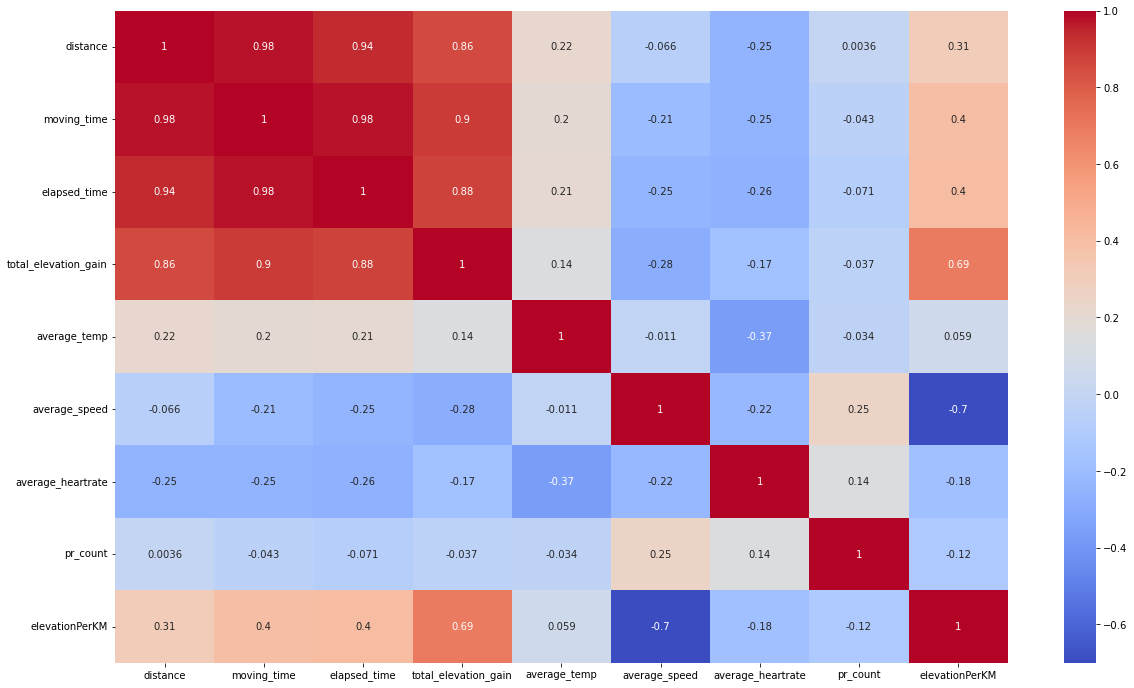

In [3]:
# Firstly I should sense check my assumption that distance and time are most important for my average speed. 
# A quick check of a correlation matrix should confirm this.
plt.figure(figsize=(20,12))
sns.heatmap(rides.corr(), annot=True, cmap='coolwarm')
#sns.heatmap(runs.corr(), annot=True, cmap='coolwarm')
plt.show()


In [4]:
run_corr_matrix = runs.corr()
rides_corr_matrix= rides.corr()
print(run_corr_matrix["average_speed"].sort_values(ascending=False))
#print(rides_corr_matrix["average_speed"].sort_values(ascending=False))

average_speed           1.000000
pr_count                0.286986
average_heartrate       0.233290
distance                0.091777
elapsed_time           -0.186777
moving_time            -0.202000
total_elevation_gain   -0.538900
elevationPerKM         -0.609173
average_temp                 NaN
Name: average_speed, dtype: float64


It looks like 'hilliness' proxied by `ElevationPerKM` is a strong influence on average pace. Note how transforming variables boosts their importance significantly.

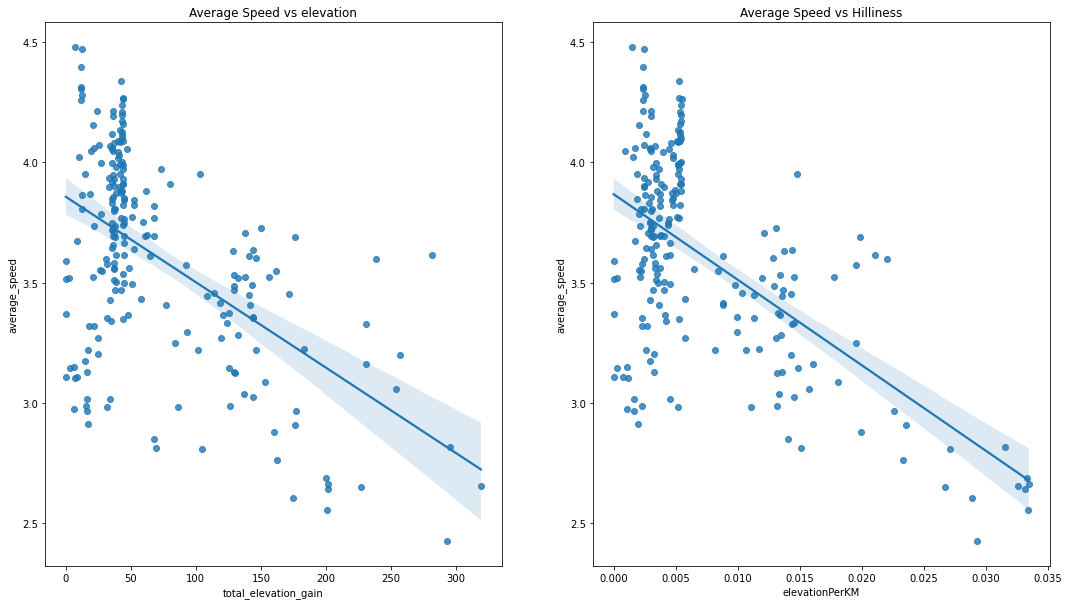

In [5]:
fig, axs= plt.subplots(ncols=2, figsize=(18,10))
#sns.set(style="ticks", context="talk")
sns.regplot(x='total_elevation_gain', y = 'average_speed', data = runs, ax=axs[0]).set_title("Average Speed vs elevation")
sns.regplot(x='elevationPerKM', y = 'average_speed', data = runs, ax=axs[1]).set_title("Average Speed vs Hilliness")
plt.show()

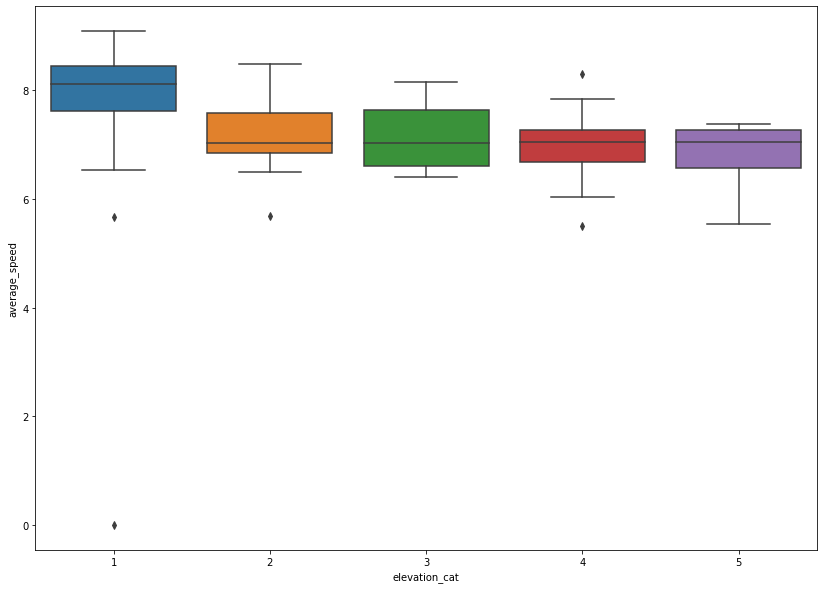

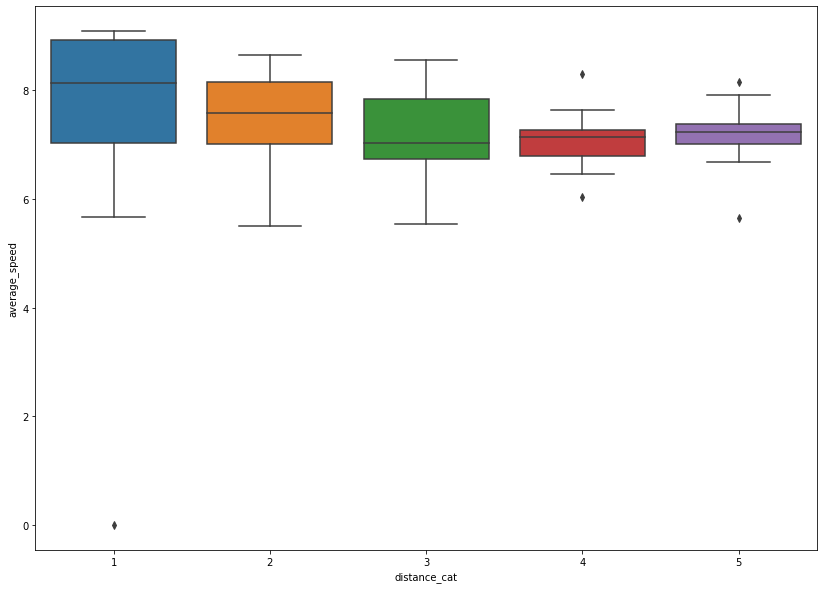

In [16]:
def print_boxplot(type_data,feature, figsize=(14, 10)):
    data = pd.concat([type_data['average_speed'], type_data[feature]], axis=1)
    f, ax = plt.subplots(figsize=figsize)
    fig = sns.boxplot(x=feature, y="average_speed", data=data)

#Too many different elevations so group them.
rides["elevation_cat"]= pd.cut(
    rides.total_elevation_gain,
    bins=5,
    labels=[1,2,3,4,5]
)
print_boxplot(rides,'elevation_cat')
# Let's check the same for distance
rides["distance_cat"]= pd.cut(
    rides.distance,
    bins=5,
    labels=[1,2,3,4,5]
)
print_boxplot(rides,'distance_cat')

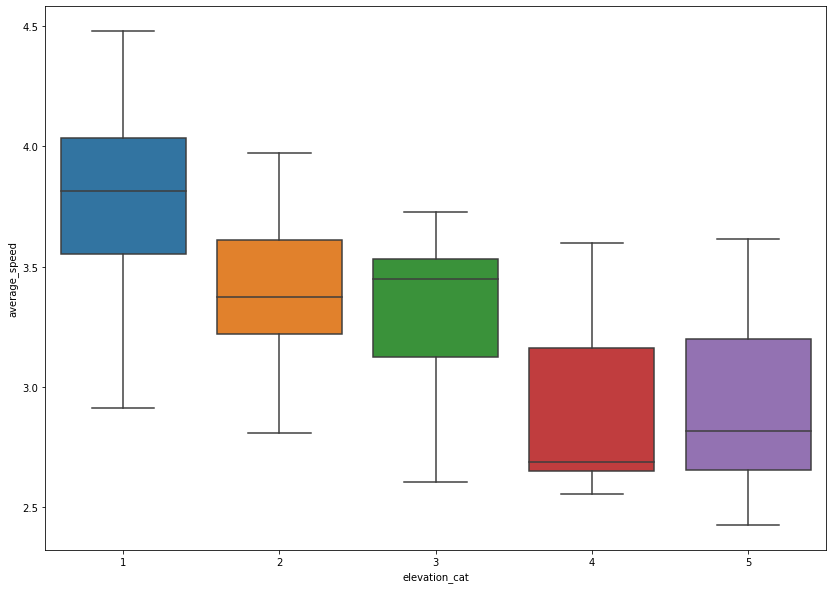

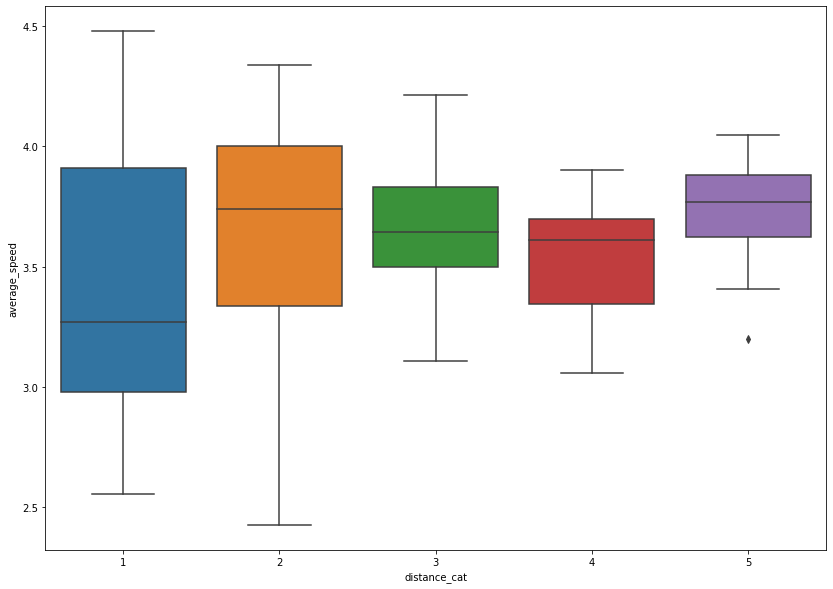

In [17]:
#Is it the same for running?
runs["elevation_cat"]= pd.cut(
    runs.total_elevation_gain,
    bins=5,
    labels=[1,2,3,4,5]
)
runs["distance_cat"]= pd.cut(
    runs.distance,
    bins=5,
    labels=[1,2,3,4,5]
)
print_boxplot(runs,'elevation_cat')
print_boxplot(runs,'distance_cat')

It looks like distance and elevation affect my runs and bikes. Time to quantify the relationships so I can answer does elevation affect my run or my bike pace more? Does distance affect my run or my bike more? Are there threshold levels where my performance deteriorates?

Because I'm examining the relationship between independent variables (distance and elevation) and a dependent variable (average speed) I have a few options for modelling the relationship. The sample is relatively small so I don't want to select any complex or deep ML models. If accurate prediction was the most important consideration then I might pre-train a deep learning model and then fit it to my additional data but this would be laborious, and would of course be difficult to interrogate the relationship which is what I really care about.

From traditional statistics I can check linear and nonlinear regression. There are other traditional statistical options like GLM but some simple regression should serve as a starting point.
From the ML field I'll check a SVR, XGBoost and Random Forest Regressor.

I want to form a view of how difficult any activity should be for me based on distance and elevation. From there I can weight my performances over time.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
regr=LinearRegression()
model = Pipeline([
  ('poly', PolynomialFeatures(degree=2)),
  ('linear', LinearRegression(fit_intercept=False))
])
rides.elevationPerKM.fillna(df.average_temp.median(), inplace=True)

X=runs[["distance","elevationPerKM"]]
y=runs["average_speed"]
regr.fit(X,y)
model.fit(X,y)
print("distance and elevation coefficients for running: {}, R-squared of: {}".format(regr.coef_,regr.score(X,y)))
print("R-squared of polynomial regression for running: {}".format(model.score(X,y)))

X=rides[["distance","elevationPerKM"]]
y=rides["average_speed"]
regr.fit(X,y)
model.fit(X,y)
print("distance and elevation coefficients for riding: {}, R-squared of: {}".format(regr.coef_,regr.score(X,y)))
print("R-squared of polynomial regression for riding: {}".format(model.score(X,y)))

distance and elevation coefficients for running: [-2.52500069e-06 -3.57667646e+01], R-squared of: 0.37153819157855505
R-squared of polynomial regression for running: 0.3848290908206994
distance and elevation coefficients for riding: [-8.04035742e-06 -5.61910239e-01], R-squared of: 0.5245777283174979
R-squared of polynomial regression for riding: 0.7383714791615553


Distance and hilliness both appear to have an explanatory effect on average speed but riding speed seems to be more dependent than running. Also, distance has a much greater affect on riding speed than hilliness - the opposite is the case for running.

## Predicting performance ##
The predictions from traditional regression were okay but I think we can do better with some out of the box ML predictions. If the predictions are good enough then deviation from expected is a good proxy for weighted fitness. 

In [37]:
# Before I set up the processing pipeline, let's do a quick check on the nulls in the dataset
def print_nulls(column_name):
    print(rides[column_name].isnull().value_counts())

[print_nulls(i) for i in rides.columns]

False    86
Name: athlete, dtype: int64
False    86
Name: name, dtype: int64
False    86
Name: distance, dtype: int64
False    86
Name: moving_time, dtype: int64
False    86
Name: elapsed_time, dtype: int64
False    86
Name: total_elevation_gain, dtype: int64
False    86
Name: type, dtype: int64
False    67
True     19
Name: average_temp, dtype: int64
False    86
Name: start_date_local, dtype: int64
True    86
Name: location_city, dtype: int64
False    86
Name: average_speed, dtype: int64
True     63
False    23
Name: average_heartrate, dtype: int64
False    86
Name: pr_count, dtype: int64
False    86
Name: start_time, dtype: int64
False    86
Name: start_date, dtype: int64
False    85
True      1
Name: elevationPerKM, dtype: int64
False    81
True      5
Name: prevMonthDist, dtype: int64
False    81
True      5
Name: prevMonthElevation, dtype: int64
False    68
True     18
Name: prevWeekDist, dtype: int64
False    68
True     18
Name: prevWeekElevation, dtype: int64
False    81
True  

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline


# PIPELINE CELL
# Handle nulls, Scale numerical features, Shuffle split - I don't need to label encode anything other than type which I'll do explicitly.
# Remove columns that won't be relevant to_drop= [["athlete","name","start_latlng","start_date_local","location_city","location_country","max_speed","has_heartrate","elev_high","elev_low","moving_time","elapsed_time","kudos_count","average_speed""pr_count","average_heartrate","max_heartrate"]]
preData= df[["distance","elevationPerKM","type","average_temp","average_speed"]]
le=LabelEncoder()
preData['type']=le.fit_transform(df['type'])
preData.average_temp.fillna(df.average_temp.median(), inplace=True)
preData.elevationPerKM.fillna(df.average_temp.median(), inplace=True)

split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(preData, preData["average_speed"]):
    train_set = preData.loc[train_index]
    test_set = preData.loc[test_index]

y_train=train_set["average_speed"]
X_train=train_set.drop("average_speed", axis=1)
y_test=test_set["average_speed"]
X_test=test_set.drop("average_speed", axis=1)

# Pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

num_attributes = [el for el in list(
X_train.select_dtypes(include=[np.number])
)]

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attributes)
], remainder='passthrough')

test_prepared = full_pipeline.fit_transform(X_test)
train_prepared = full_pipeline.fit_transform(X_train)



In [20]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#SVR
svr_regr= SVR()
svr_regr.fit(X_train,y_train)
print(f"Train score : {svr_regr.score(X_train,y_train)}")
print(f"Validation score : {svr_regr.score(X_test,y_test)}")

#Random Forest
forest_regr = RandomForestRegressor(n_estimators=20)
forest_regr.fit(X_train,y_train)
print(f"Train score : {forest_regr.score(X_train,y_train)}")
print(f"Validation score : {forest_regr.score(X_test,y_test)}")

# XGBoost
XGB_regr=XGBRegressor(learning_rate=0.1)
XGB_regr.fit(X_train,y_train)
print(f"Train score : {XGB_regr.score(X_train,y_train)}")
print(f"Validation score : {XGB_regr.score(X_test,y_test)}")


Train score : 0.7370797777970197
Validation score : 0.6766597372887788
Train score : 0.9841047546339224
Validation score : 0.9597588109673069
Train score : 0.9977422734837402
Validation score : 0.9504389928296076


These are some pretty impressive scores but I won't be too happy with myself. My samples are small and I have a relatively small range of average speed when I exercise so accuracy measures will tend to be high naturally. If my main goal was to train a predictor model then I would be fine-tuning the model and transforming the data so it suits an ML regressor model better.

### Training over time ###

*Now I have examined my individual workouts I want to look at my training.*
- Is there a number/intensity/consistency of workouts which means I bike or run faster on average? Maybe I do the same workouts with less effort? 
- Is there a number/intensity/consistency of workouts where I lose condition? 

<AxesSubplot:xlabel='start_date', ylabel='distance'>

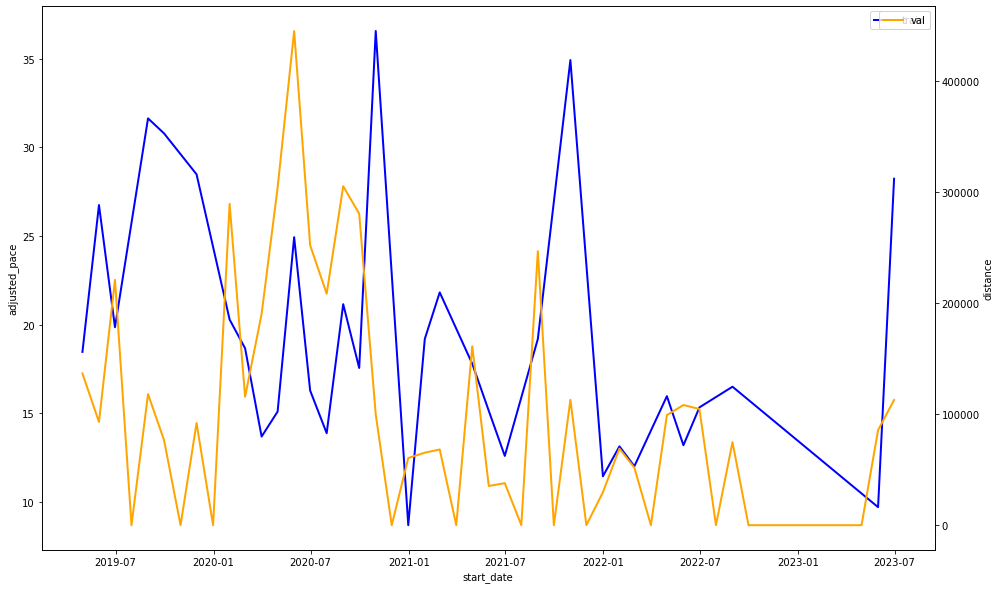

In [44]:
rides["elevation_cat"]= pd.cut(
    rides.total_elevation_gain,
    bins=5,
    labels=False
)
# Let's check the same for distance
rides["distance_cat"]= pd.cut(
    rides.distance,
    bins=5,
    labels=False
)
rides["difficulty"]= ((rides["elevation_cat"]+1)+(rides["distance_cat"]+1))

rides["adjusted_pace"]= (rides["difficulty"]/2)*rides["average_speed"]
monthly = rides.groupby(pd.Grouper(key='start_date', freq='M')).mean()
monthlyyy= rides.groupby(pd.Grouper(key='start_date', freq='M')).sum()

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=monthly["adjusted_pace"], linewidth=2, label="train",color="blue", ax=ax)
ax2 = plt.twinx()
sns.lineplot(data=monthlyyy["distance"], linewidth=2, label="val",color="orange", ax=ax2)

<AxesSubplot:xlabel='start_date', ylabel='distance'>

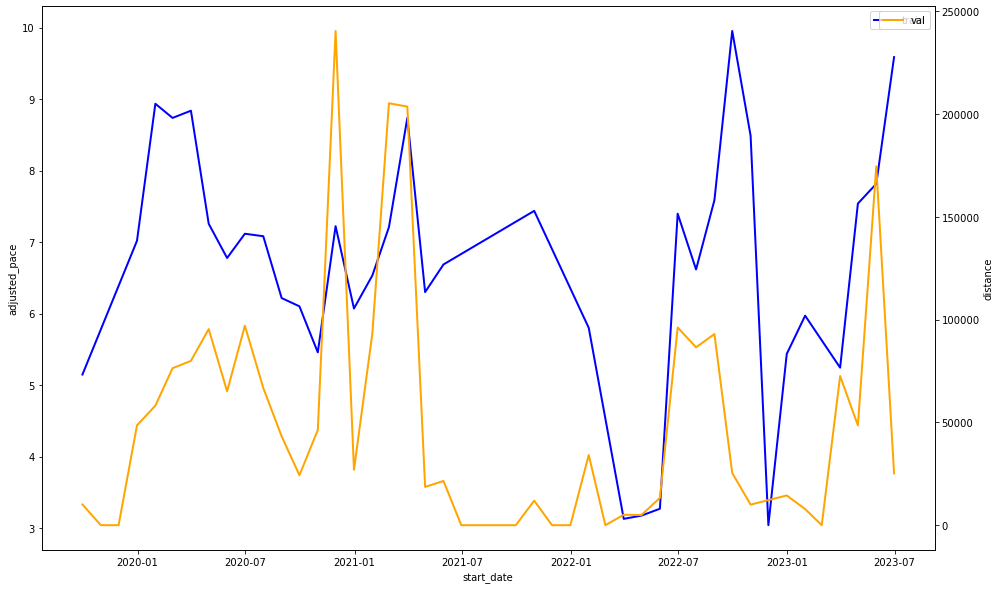

In [45]:
runs["elevation_cat"]= pd.cut(
    runs.total_elevation_gain,
    bins=5,
    labels=False
)
# Let's check the same for distance
runs["distance_cat"]= pd.cut(
    runs.distance,
    bins=5,
    labels=False
)
runs["difficulty"]= ((runs["elevation_cat"]+1)+(runs["distance_cat"]+1))

runs["adjusted_pace"]= (runs["difficulty"]/2)*runs["average_speed"]
monthly = runs.groupby(pd.Grouper(key='start_date', freq='M')).mean()
monthlyyy= runs.groupby(pd.Grouper(key='start_date', freq='M')).sum()

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=monthly["adjusted_pace"], linewidth=2, label="train",color="blue", ax=ax)
ax2 = plt.twinx()
sns.lineplot(data=monthlyyy["distance"], linewidth=2, label="val",color="orange", ax=ax2)


In [46]:
# I've got to sort by ascending date
df.sort_values(by='start_date', inplace = True) 

# Previous month aggregate distance
df_time = pd.DataFrame({"distance": df["distance"].tolist()},
                       index = df["start_date"])
df_time= df_time.rolling('30D',closed='left').sum()
df["prevMonthDist"]=df_time["distance"].to_numpy()

# Previous month aggregate elevation
df_time = pd.DataFrame({"elevation": df["total_elevation_gain"].tolist()},
                       index = df["start_date"])
df_time= df_time.rolling('30D', closed='left').sum()
df["prevMonthElevation"]=df_time["elevation"].to_numpy()

# Previous week aggregate distance
df_time = pd.DataFrame({"distance": df["distance"].tolist()},
                       index = df["start_date"])
df_time= df_time.rolling('7D',closed='left').sum()
df["prevWeekDist"]=df_time["distance"].to_numpy()

# Previous week aggregate elevation
df_time = pd.DataFrame({"elevation": df["total_elevation_gain"].tolist()},
                       index = df["start_date"])
df_time= df_time.rolling('7D',closed='left').sum()
df["prevWeekElevation"]=df_time["elevation"].to_numpy()

# Previous month average hilliness
df["prevMonthHills"]= df["prevMonthElevation"]/df["prevMonthDist"]



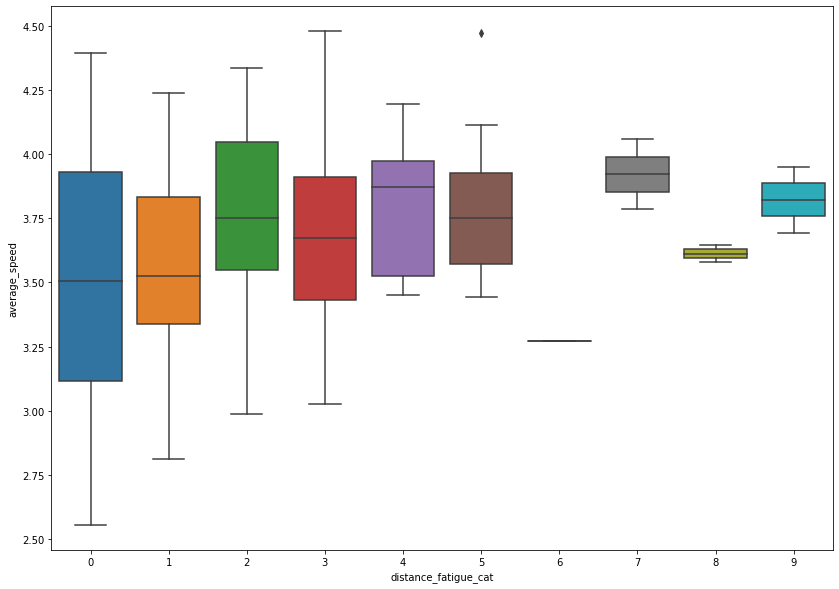

In [47]:
def print_boxplot(type_data,feature, figsize=(14, 10)):
    data = pd.concat([type_data['average_speed'], type_data[feature]], axis=1)
    f, ax = plt.subplots(figsize=figsize)
    fig = sns.boxplot(x=feature, y="average_speed", data=data)

df["distance_load_cat"]= pd.cut(
    df.prevMonthDist,
    bins=10,
    labels=[*range(0,10)]
)

df["elevation_load_cat"]= pd.cut(
    df.prevMonthElevation,
    bins=10,
    labels=[*range(0,10)]
)

df["distance_fatigue_cat"]= pd.cut(
    df.prevWeekDist,
    bins=10,
    labels=[*range(0,10)]
)

df["elevation_fatigue_cat"]= pd.cut(
    df.prevWeekElevation,
    bins=10,
    labels=[*range(0,10)]
)

runs= df.loc[df["type"]=="Run"]
runs.reset_index(inplace=True)

rides=df.loc[df["type"]=="Ride"]
rides.reset_index(inplace=True)
print_boxplot(runs,"distance_fatigue_cat")


In [126]:
# What does the rank of previous month distance mean for average run pace?
runs["pace"]= 1000/runs["average_speed"]/60
low_load= runs[["distance","prevMonthDist","moving_time","pace"]].loc[runs["distance_load_cat"]<=6]
high_load=runs[["distance","prevMonthDist","moving_time","pace"]].loc[runs["distance_load_cat"]>=6]
print("low: {}, high: {}".format(low_load["pace"].mean(),high_load["pace"].mean()))

low: 4.697956721295396, high: 4.281544446491037


It looks like my goldilocks level of prior month training is 6 or 7.
Less than 6 and I'm half a minute slower. 

In [127]:
# What does the rank of previous week distance mean for average run pace?
low_load= runs[["distance","prevWeekDist","moving_time","pace"]].loc[runs["distance_fatigue_cat"]<=1]
high_load=runs[["distance","prevWeekDist","moving_time","pace"]].loc[runs["distance_fatigue_cat"]>=9]
print("low: {}, high: {}".format(low_load["pace"].mean(),high_load["pace"].mean()))

low: 4.8667052472841466, high: 4.365081159562884


In [128]:
# What does the rank of previous week distance mean for average run pace?
low_load= runs[["distance","prevMonthElevation","moving_time","pace"]].loc[runs["elevation_load_cat"]<=1]
high_load=runs[["distance","prevMonthElevation","moving_time","pace"]].loc[runs["elevation_load_cat"]>=9]
print("low: {}, high: {}".format(low_load["pace"].mean(),high_load["pace"].mean()))

low: 4.957085214664032, high: 4.382604645533375


In [48]:
# Looks like distance and elevation are too closely linked so I'll just use distance for the longer training lookback

# Training block (10 weeks) distance
df_time = pd.DataFrame({"distance": df["distance"].tolist()},
                       index = df["start_date"])
df_time= df_time.rolling('70D',closed='left').sum()
df["prevBlockDist"]=df_time["distance"].to_numpy()

# Training block categorisation
df["training_block_cat"]= pd.cut(
    df.prevBlockDist,
    bins=10,
    labels=[*range(0,10)]
)

runs= df.loc[df["type"]=="Run"]
runs["pace"]= 1000/runs["average_speed"]/60
runs.reset_index(inplace=True)
low_load= runs[["distance","prevBlockDist","moving_time","pace"]].loc[runs["training_block_cat"]<=4]
high_load=runs[["distance","prevBlockDist","moving_time","pace"]].loc[runs["training_block_cat"]>=7]
print("low: {}, high: {}".format(low_load["pace"].mean(),high_load["pace"].mean()))

low: 4.8474305469177175, high: 4.197823667480974


In [53]:
runs= df.loc[df["type"]=="Run"]
runsData= runs[["distance","elevationPerKM","prevMonthDist","prevMonthElevation","prevBlockDist"]]
runsData.prevMonthDist.fillna(0, inplace=True)
runsData.prevMonthElevation.fillna(0, inplace=True)
runsData.prevBlockDist.fillna(0, inplace=True)
X=runsData
y=runs["average_speed"]
regr.fit(X,y)
model.fit(X,y)
print("distance and elevation coefficients for running: {}, R-squared of: {}".format(regr.coef_,regr.score(X,y)))
print("R-squared of polynomial regression for running: {}".format(model.score(X,y)))

distance and elevation coefficients for running: [-1.08506677e-05 -2.24336628e+01  1.08699557e-06 -1.22416977e-04
  8.97589782e-07], R-squared of: 0.6451175366384065
R-squared of polynomial regression for running: 0.7340841725638276


In [54]:
rides= df.loc[df["type"]=="Ride"]
ridesData= rides[["distance","elevationPerKM","prevMonthDist","prevMonthElevation","prevBlockDist"]]

# [print_nulls(i) for i in ridesData.columns]
ridesData.loc[ridesData["prevMonthDist"].isnull()]

,distance,elevationPerKM,prevMonthDist,prevMonthElevation,prevBlockDist
306,55493.0,0.010448,NaN,NaN,NaN
299,118016.0,0.007050,NaN,NaN,220892.0
298,76614.0,0.019605,NaN,NaN,118016.0
296,92002.0,0.010195,NaN,NaN,86688.8
102,14632.9,0.007736,NaN,NaN,73174.0
96,29673.1,0.008425,NaN,NaN,NaN


In [56]:
rides= df.loc[df["type"]=="Ride"]
ridesData= rides[["distance","elevationPerKM","prevMonthDist","prevMonthElevation","prevBlockDist"]]
ridesData.prevMonthDist.fillna(0, inplace=True)
ridesData.prevMonthElevation.fillna(0, inplace=True)
ridesData.prevBlockDist.fillna(0, inplace=True)
X=ridesData
y=rides["average_speed"]
regr.fit(X,y)
model.fit(X,y)
print("distance and elevation coefficients for riding: {}, R-squared of: {}".format(regr.coef_,regr.score(X,y)))
print("R-squared of polynomial regression for riding: {}".format(model.score(X,y)))

distance and elevation coefficients for riding: [-3.38945683e-06 -1.01510772e+02 -4.43146929e-06  2.41566492e-04
  1.09937790e-06], R-squared of: 0.5385203970354095
R-squared of polynomial regression for riding: 0.5868962399137374
